# Load Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer                   
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
import tensorflow as tf
from tensorflow import keras

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Load data and clean it

In [3]:
df = pd.read_excel('../../NLP Preprocessing/02_Resources/Climate_change_links.xlsx')
data = df[["VideoID", "Effectiveness"]]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,1.0
1,eRLJscAlk1M,5.0
2,VbiRNT_gWUQ,2.0
3,5dVcn8NjbwY,NaN
4,5scez5dqtAc,4.0
...,...,...
186,TZ0j6kr4ZJ0,3.0
187,8DiWzvE52ZY,1.0
188,OwqIy8Ikv-c,2.0
189,lPgZfhnCAdI,1.0


In [4]:
# clean data
data = data.loc[(data["Effectiveness"] == 1) | (data["Effectiveness"] == 2) | (data["Effectiveness"] == 3) | (data["Effectiveness"] == 4) | (data["Effectiveness"] == 5)]
data = data.reset_index()
del data["index"]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,1.0
1,eRLJscAlk1M,5.0
2,VbiRNT_gWUQ,2.0
3,5scez5dqtAc,4.0
4,JDcro7dPqpA,2.0
...,...,...
164,TZ0j6kr4ZJ0,3.0
165,8DiWzvE52ZY,1.0
166,OwqIy8Ikv-c,2.0
167,lPgZfhnCAdI,1.0


In [5]:
## Custom encoder
def custom_encoder(df):
    df.replace(to_replace = 1.0, value = "neg", inplace=True)
    df.replace(to_replace = 2.0, value = "neg", inplace=True)
    df.replace(to_replace = 4.0, value = "pos", inplace=True)
    df.replace(to_replace = 5.0, value = "pos", inplace=True)

custom_encoder(df['Effectiveness'])

data = df[["VideoID", "Effectiveness"]]
data = data[data["Effectiveness"] != 3]
data = data.loc[(data["Effectiveness"] == 'pos') | (data["Effectiveness"] == 'neg')]
data = data.reset_index()
del data["index"]
data

,VideoID,Effectiveness
0,pvuN_WvF1to,neg
1,eRLJscAlk1M,pos
2,VbiRNT_gWUQ,neg
3,5scez5dqtAc,pos
4,JDcro7dPqpA,neg
...,...,...
132,JYZpxRy5Mfg,pos
133,xXMlFFY9uEI,pos
134,8DiWzvE52ZY,neg
135,OwqIy8Ikv-c,neg


C:\Users\Jared\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

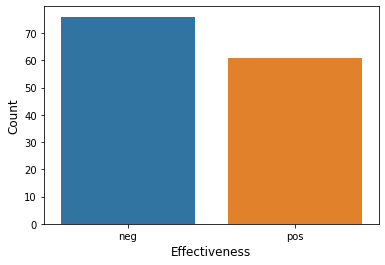

In [6]:
# visulaise 
plot = sns.countplot(data['Effectiveness'], order=['neg','pos'])
plot.set_xlabel("Effectiveness", fontsize = 12)
plot.set_ylabel("Count", fontsize = 12)

In [7]:
## get documnets (pre-processd comments)
documents = []
for i in range(len(data)):
    VideoID = data["VideoID"][i]
    comment = pd.read_csv("../../NLP Preprocessing/03_Processed_Comments/"+VideoID+"/"+VideoID+"_all_words.csv")
    documents.append(list(comment["0"]))

In [8]:
## create two new columns of the pre-processed data in list and string form
data['cleaned'] = documents
data['cleaned_string'] = [' '.join(map(str, l)) for l in data['cleaned']]

In [9]:
# function to plot confusion matrix
def plot_conf_matrix(conf_matrix):
    group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    
# function to get results of algorithm
def get_results(y_test, y_pred):
    # print classification report
    print(classification_report(y_test, y_pred))
    # plot confusion matrix
    plot_conf_matrix(confusion_matrix(y_test, y_pred))

# Machine Learning

In [10]:
# set vectorizer
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 1))

# split training and test set
X = data.cleaned_string
y = data.Effectiveness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Shallow Algorithms

### Random Forest Algorithm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

         neg       0.68      0.86      0.76        22
         pos       0.79      0.55      0.65        20

    accuracy                           0.71        42
   macro avg       0.73      0.71      0.70        42
weighted avg       0.73      0.71      0.71        42



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


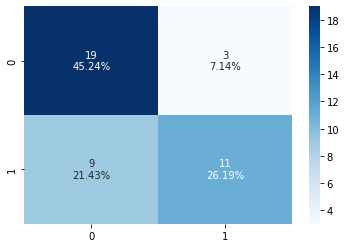

In [11]:
# create pipeline for algorithm
randFor = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', RandomForestClassifier(n_estimators=1000, random_state=1, criterion='entropy', oob_score=True, verbose=1)),
                   ])

# open pickle file
randFor_71_f = open('../Shallow machine learning/pickles/randFor_71.pickle', "rb")
randFor_train = pickle.load(randFor_71_f)
randFor_71_f.close()

y_pred_RandFor = randFor_train.predict(X_test)

# get results of algorithm
get_results(y_test, y_pred_RandFor)

### Stochastic Gradient Descent Classifier 

              precision    recall  f1-score   support

         neg       0.76      0.73      0.74        22
         pos       0.71      0.75      0.73        20

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42



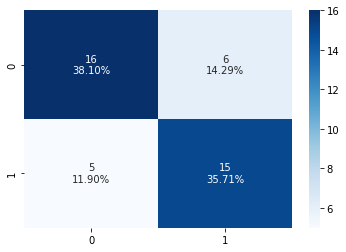

In [12]:
# create pipeline for algorithm
SGD = Pipeline([('vect', vectorizer),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None, random_state=12)),
               ])

# open pickle file
SGD_74_f = open('../Shallow machine learning/pickles/SGD_74.pickle', "rb")
SGD_train = pickle.load(SGD_74_f)
SGD_74_f.close()

# get prediction from algorithm
y_pred_SGD = SGD_train.predict(X_test)

# get results of algorithm
get_results(y_test, y_pred_SGD)

### XG Boost

              precision    recall  f1-score   support

         neg       0.79      0.68      0.73        22
         pos       0.70      0.80      0.74        20

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42



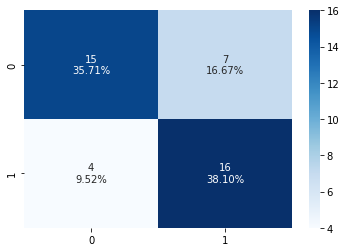

In [13]:
# create pipeline for algorithm
XGB = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier()),
               ])

# open pickle file
XGB_74_f = open('../Shallow machine learning/pickles/XGB_74.pickle', "rb")
XGB_train = pickle.load(XGB_74_f)
XGB_74_f.close()

# get prediction from algorithm
y_pred_XGB = XGB_train.predict(X_test)

# get results of algorithm
get_results(y_test, y_pred_XGB)

### Logistic Regression Classifier

              precision    recall  f1-score   support

         neg       0.78      0.82      0.80        22
         pos       0.79      0.75      0.77        20

    accuracy                           0.79        42
   macro avg       0.79      0.78      0.78        42
weighted avg       0.79      0.79      0.79        42



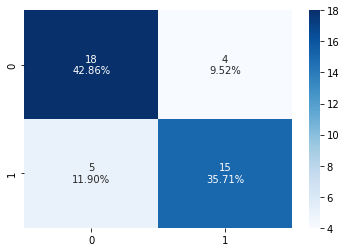

In [14]:
# create pipeline for algorithm
logreg = Pipeline([('vect', vectorizer),
                   ('clf', LogisticRegression(n_jobs=1, C=100000.0, penalty='l1', solver='liblinear', random_state=12)),
                  ])

# open pickle file
logreg_79_f = open('../Shallow machine learning/pickles/logreg_79.pickle', "rb")
logreg_train = pickle.load(logreg_79_f)
logreg_79_f.close()

# get prediction from algorithm
y_pred_logreg = logreg_train.predict(X_test)

# get results of algorithm
get_results(y_test, y_pred_logreg)

## Deep Learning Algorithm

### Convolutional Neural Network (CNN)

In [15]:
## Create CNN model
model = Sequential()
embedding_dim = 100
vocab_size = 410796
maxlen = 100
# input embedded layer
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# convolutional layer with relu activation
model.add(layers.Conv1D(128, 7, activation='relu'))
# max pooling layer
model.add(layers.GlobalMaxPooling1D())
# hidden layer with 10 neurons with a softmax activation
model.add(layers.Dense(10, activation='softmax'))
# output layer with a sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                     tf.keras.metrics.TruePositives(),
                                                                     tf.keras.metrics.TrueNegatives(),
                                                                     tf.keras.metrics.FalsePositives(),
                                                                     tf.keras.metrics.FalseNegatives(),   
                                                                     tf.keras.metrics.Precision(class_id=None),
                                                                     tf.keras.metrics.Recall()])

In [16]:
# open y_train file
y_train_f = open('../Deep learning/pickles/y_train.pickle', "rb")
y_train_CNN = pickle.load(y_train_f)
y_train_f.close()

# open y_test file
y_test_f = open('../Deep learning/pickles/y_test.pickle', "rb")
y_test_CNN = pickle.load(y_test_f)
y_test_f.close()

# open X_train file
X_train_f = open('../Deep learning/pickles/X_train.pickle', "rb")
X_train_CNN = pickle.load(X_train_f)
X_train_f.close()

# open X_test file
X_test_f = open('../Deep learning/pickles/X_test.pickle', "rb")
X_test_CNN = pickle.load(X_test_f)
X_test_f.close()

In [17]:
# get saved model
model = keras.models.load_model("../Deep learning/CNN_82")

Testing Accuracy:  82.35294222831726


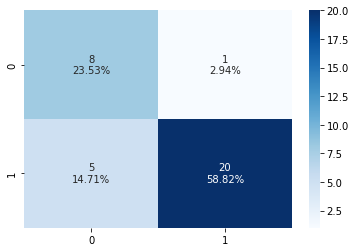

In [18]:
# Evaluate model
loss, CNN_accuracy, tp, tn, fp, fn, precision, recall = model.evaluate(X_test_CNN, y_test_CNN, verbose=False)
print("Testing Accuracy: ", CNN_accuracy*100)

# Creating confusion matrix
plot_conf_matrix(np.array([[tp, fp], 
                          [fn, tn]]))

# Comparing the Algorithms

In [19]:
## Evaluate algorithms
def evaluate(y_test, y_pred_dict):
    table = pd.DataFrame({}, index=['Accuracy', 'Precision', 'Recall','F1-score']) 
    
    for model in y_pred_dict:
        report = classification_report(y_test, y_pred_dict[model], digits=2, output_dict=True)
        
        cols = [report['accuracy'],(report['neg']['precision']+report['pos']['precision'])/2,(report['neg']['recall']+report['pos']['recall'])/2,(report['neg']['f1-score']+report['pos']['f1-score'])/2]
        table[model] = cols
    
    # add CNN results
    table.insert(table.shape[1],"CNN", [0.8235,0.8888,0.6153,0.7272], True)
    
    # convert to percentage
    table = table*100
    
    # Add 'Best Score' column
    table['Best Score'] = table.idxmax(axis=1)
    
    return table.round(2)

In [20]:
# dictionary of algorithms and their respective predictions
y_pred_dict = {
               "Random Forest": y_pred_RandFor,
               "SGD": y_pred_SGD, 
               "XGBoost": y_pred_XGB,
               "Logistic Regression": y_pred_logreg,
              }

table = evaluate(y_test, y_pred_dict)
table

,Random Forest,SGD,XGBoost,Logistic Regression,CNN,Best Score
Accuracy,71.43,73.81,73.81,78.57,82.35,CNN
Precision,73.21,73.81,74.26,78.60,88.88,CNN
Recall,70.68,73.86,74.09,78.41,61.53,Logistic Regression
F1-score,70.35,73.79,73.79,78.46,72.72,Logistic Regression


C:\Users\Jared\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


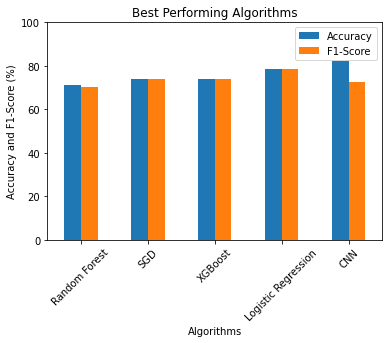

In [21]:
## Plot
# get only accuracy and F1-score
accuracy_f1 = table.iloc[[0,3]]
accuracy_f1.drop(accuracy_f1.columns[len(accuracy_f1.columns)-1], axis=1, inplace=True)
# get all algoritms with accuracy >= 70
accuracy_f1 = accuracy_f1.loc[:, accuracy_f1.gt(70).any()]

# convert numpy array into list
accuracy_values = [item for sublist in accuracy_f1.iloc[[0]].values.tolist() for item in sublist]
f1_values = [item for sublist in accuracy_f1.iloc[[1]].values.tolist() for item in sublist]

plotdata = pd.DataFrame({
    "Accuracy" : accuracy_values,
    "F1-Score" : f1_values
    }, 
    index = list(accuracy_f1)
)
plotdata.plot(kind="bar")   

plt.title("Best Performing Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy and F1-Score (%)")
plt.xticks(rotation=45, ha="center")
plt.ylim([0,100])
plt.legend(loc='best')
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]    
#plt.savefig('Best Performing Algorithms.png', bbox_inches = "tight")

# Create Pipeline to classify a video

In [22]:
## get YouTube ID
def getID(url):
    from pytube import extract
    print("Getting YouTube ID...")
    return extract.video_id(url)

In [23]:
## download comments
def downloadComments(videoID):
    import os
    print("Downloading Comments...")
    os.system("youtube-comment-downloader --youtubeid=" + videoID + " --output Comments/" + videoID + ".json")

In [29]:
# Import packages
import pandas as pd
import string
import re
import nltk
import nltk.sentiment.util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
import numpy as np
import math

sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# function to clean comments
def clean_text(text):
    
    # remove symbols and Emojis
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    
    # tokenize the data
    text = nltk.word_tokenize(text)
    
    # lemmatize
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [lemmatizer.lemmatize(t, 'v') for t in text]
    
    # mark Negation
    tokens_neg_marked = nltk.sentiment.util.mark_negation(text)
    
    # remove stopwords
    text = [t for t in tokens_neg_marked
             if t.replace("_NEG", "").isalnum() and
             t.replace("_NEG", "") not in sw]
    
    return text

In [30]:
def getSentenceTrain():
    # open sentences_train file
    sentences_train_f = open('../Deep learning/pickles/sentences_train.pickle', "rb")
    sentences_train = pickle.load(sentences_train_f)
    sentences_train_f.close()
    return sentences_train

In [31]:
def vote(test_point, _test):
    print("Voting on video effectivess...\n")
    pos_weighting = []
    result = ''
    confidence = 0
    algos_score = 0
    
    algorithms = [
             {'name': 'Random Forest', 'accuracy': accuracy_score(y_test, y_pred_RandFor)*100, 'trained': randFor_train},
             {'name': 'SGD', 'accuracy': accuracy_score(y_test, y_pred_SGD)*100, 'trained': SGD_train},
             {'name': 'XGBoost', 'accuracy':  accuracy_score(y_test, y_pred_SGD)*100, 'trained': XGB_train},
             {'name': 'Logistic Regression', 'accuracy': accuracy_score(y_test, y_pred_logreg)*100, 'trained': logreg_train},
             {'name': 'CNN', 'accuracy': CNN_accuracy*100, 'trained': model}
        ]
    
    for algo in algorithms:
        weight = algo['accuracy']
        algos_score += weight
        if algo['name'] == "CNN":
            pred = algo['trained'].predict(_test)
            if pred[0][0] > 0.5:
                pos_weighting.append(weight)
            print("CNN voted for: effective" if pred[0][0]>0.5 else "CNN voted for: ineffective")
        else:
            pred = algo['trained'].predict(test_point)
            if pred == 'pos':
                pos_weighting.append(weight)
            print(algo['name'] + " voted for: effective" if pred=='pos' else algo['name'] + " voted for: ineffective")

    pos_result = sum(pos_weighting)/algos_score
    if pos_result < 0.5:
        result = 'ineffective'
        confidence = 1-pos_result
    else:
        result = 'effective'
        confidence = pos_result
        
    print("\nThis video is \033[1m" + result + "\033[0m with a confidence of \033[1m" + str(round(confidence*100,2)) + "% \033[0m")

# Final tool to classify a video

In [32]:
def quantizeEffectiveness(url):
    # 1. Get YouTube ID
    videoID = getID(url)
    
    # 2. Download comments
    downloadComments(videoID)
    
    # 3. Clean comments
    print("Cleaning Comments...")
    df = pd.read_json('Comments/'+ videoID + '.json', lines=True)
    df['text'] = df['text'].apply(lambda x: clean_text(x))

    all_words = []        
    for i in range(len(df)):
        all_words = all_words + df['text'][i]

    df_csv = pd.DataFrame(all_words)
    df_csv.to_csv('Processed Comments/' + videoID + '_all_words.csv', index=False)
    
    # 4. Create test dataframe
    test = pd.DataFrame([[videoID]], columns=['VideoID'])
    
    # 5. Get documnets (pre-processd comments)
    test_documents = []
    comment = pd.read_csv("Processed Comments/" + videoID + "_all_words.csv")
    test_documents.append(list(comment["0"]))
    test['cleaned'] = test_documents
    test['cleaned_string'] = [' '.join(map(str, l)) for l in test['cleaned']]
    
    # 6. Get ML test point
    test_point = test.cleaned_string
    test_sentence = test['cleaned_string'].values
    
    # 7. Get trained sentences
    sentences_train = getSentenceTrain()
    
    # 8. Tokenize the data
    print("Tokenizing the data...")
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    
    # 9. Get DL test point
    _test = pad_sequences(tokenizer.texts_to_sequences(test_sentence), padding='post', maxlen=100)
    
    # 10. Vote on video effectiveness
    vote(test_point,_test)

In [33]:
quantizeEffectiveness("https://www.youtube.com/watch?v=DhhVr5iLF-c")

Getting YouTube ID...
Cleaning Comments...
Tokenizing the data...
Voting on video effectivess...



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


Random Forest voted for: effective
SGD voted for: effective
XGBoost voted for: effective
Logistic Regression voted for: effective
CNN voted for: ineffective

This video is effective with a confidence of 78.33% 
